<a href="https://colab.research.google.com/github/JotaPMendes/cursos/blob/main/classificacao_sentimento_cnn_2021/notebooks/classificacao_sentimento_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Etapa 1: Importação das bibliotecas

In [ ]:
import numpy as np
import math
import re
import pandas as pd
from bs4 import BeautifulSoup
from google.colab import drive
import zipfile
import seaborn as sns
import spacy as sp
import string
import random
import matplotlib.pyplot as plt

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
tf.__version__

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


'2.11.0'

In [ ]:
from tensorflow.keras import layers
import tensorflow_datasets as tfds

# Etapa 2: Pré-processamento dos dados

## Carregamento dos arquivos

In [ ]:
drive.mount("/content/drive")              # Conectando na biblioteca do drive

Mounted at /content/drive


In [ ]:
from google.colab import drive             # Importando a biblioteca do drive para poder puxar o arquivo.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = '/content/drive/MyDrive/trainingandtestdata.zip'          # Criando um atalho para o arquivo na bilbioteca
zip_object = zipfile.ZipFile(file = path, mode = 'r')           #  Usando o zip para ler o arquivo 'path'
zip_object.extractall('./')                                # Extraindo todos os dados do arquivo zipado
zip_object.close()                  # Fechando a biblioteca do zip, para não ocupar memória

In [ ]:
cols = ['sentiment', 'id', 'date', 'query', 'user', 'text']     # Nomeando as colunas do arquivo

In [ ]:
train_data = pd.read_csv('/content/trainingandtestdata/train.csv', header = None,
                         names = cols, engine = 'python', encoding = 'latin1')      # Criando o primeiro treinamento, usando as colunas feitas anteriormente

In [ ]:
train_data.shape       # Olhando a quantidade de dados que existe no arquivo (linhas, colunas)

(1600000, 6)

In [ ]:
train_data.head()   # Trazendo os dados de forma visual (início do arquivo)

,sentiment,id,date,query,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [ ]:
train_data.tail()   # Trazendo os dados de forma visual (final do arquivo)

,sentiment,id,date,query,user,text
1599995,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599996,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...
1599999,4,2193602129,Tue Jun 16 08:40:50 PDT 2009,NO_QUERY,RyanTrevMorris,happy #charitytuesday @theNSPCC @SparksCharity...


In [ ]:
train_data.sentiment.unique()     # Verificando em quantos sentimentos foram segmentados o database

array([0, 4])

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


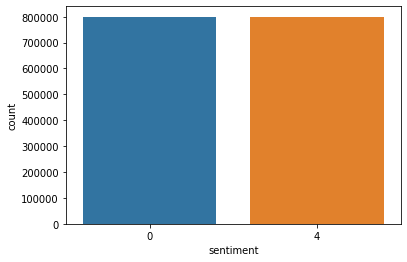

In [ ]:
sns.countplot(train_data.sentiment);    # Observando graficamente a segmentação, para esclarecer quantos sentimentos são (nesse caso 2)

In [ ]:
test_data = pd.read_csv("/content/trainingandtestdata/test.csv",
  header = None,
  names = cols,
  engine = "python",
  encoding = "latin1"
  )          # Lendo o documento de teste do database

In [ ]:
test_data.head()     # Verificando as 5 primeiras classificações presentes no arquivo

,sentiment,id,date,query,user,text
0,4,3,Mon May 11 03:17:40 UTC 2009,kindle2,tpryan,@stellargirl I loooooooovvvvvveee my Kindle2. ...
1,4,4,Mon May 11 03:18:03 UTC 2009,kindle2,vcu451,Reading my kindle2... Love it... Lee childs i...
2,4,5,Mon May 11 03:18:54 UTC 2009,kindle2,chadfu,"Ok, first assesment of the #kindle2 ...it fuck..."
3,4,6,Mon May 11 03:19:04 UTC 2009,kindle2,SIX15,@kenburbary You'll love your Kindle2. I've had...
4,4,7,Mon May 11 03:21:41 UTC 2009,kindle2,yamarama,@mikefish Fair enough. But i have the Kindle2...


In [ ]:
test_data.shape    # Verificando o tamanho do arquivo de teste

(498, 6)

In [ ]:
test_data.sentiment.unique()     # Verificando em quantos valores foram divididos o arquivo de teste

array([4, 0, 2])

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


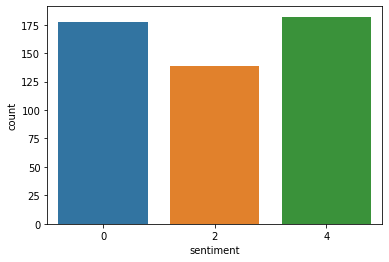

In [ ]:
sns.countplot(test_data.sentiment);    # Vendo de maneira gráfica quantos valores existem

## Pré-processamento

### Limpeza

In [ ]:
data = train_data        # Atribuindo uma variável para o arquivo de data

In [ ]:
data.drop(['id', 'date', 'query', 'user'], axis = 1, inplace = True)     # Removendo as colunas que não relevam no resultado final

In [ ]:
data.head()         # Verificando a mudança feita pelo último código

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [ ]:
X = data.iloc[:, 1].values     # Fazendo o dataset ficar em flat

In [ ]:
X

array(["@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D",
       "is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!",
       '@Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds',
       ..., 'Are you ready for your MoJo Makeover? Ask me for details ',
       'Happy 38th Birthday to my boo of alll time!!! Tupac Amaru Shakur ',
       'happy #charitytuesday @theNSPCC @SparksCharity @SpeakingUpH4H '],
      dtype=object)

In [ ]:
X.shape       # Verificando a quantidade de dados presente no dataset (agora não tem mais colunas porque está 'flat')

(1600000,)

In [ ]:
type(X)    # Verificando o tipo do arquivo, um array do numpy.

numpy.ndarray

In [ ]:
y = data.iloc[:, 0].values      # Vendo a organização do dataset 'flat', em quais posições aparece cada sentimento segregado
y

array([0, 0, 0, ..., 4, 4, 4])

In [ ]:
from sklearn.model_selection import train_test_split        # Importando a função de treino do sklearn
X, _, y, _ = train_test_split(X, y, test_size = 0.85, stratify = y)

In [ ]:
X.shape

(240000,)

In [ ]:
y.shape

(240000,)

In [ ]:
unique, counts = np.unique(y, return_counts = True)
unique, counts

(array([0, 4]), array([120000, 120000]))

In [ ]:
def clean_tweets(tweet):

  tweet = BeautifulSoup(tweet, 'lxml').get_text()
  tweet = re.sub(r"@[A-Za-z0-9]+", " ", tweet)  # remover @fulano
  tweet = re.sub(r"https?://[A-Za-z0-9./]+", ' ', tweet)  # remover hyperlinks
  tweet = re.sub(r"[^A-Za-z.!?]", ' ', tweet)  # remover caracteres
  tweet = re.sub(r" +", ' ', tweet)  # retirar espaços

  return tweet

In [ ]:
text = "@switchfoot http://twitpic.com/2y1z1 - Awww, that's a bummer. You shoulda got David Carr or Third day to do it. ;D"

In [ ]:
text = clean_tweets(text)
text

' Awww that s a bummer. You shoulda got David Carr or Third day to do it. D'

In [ ]:
nlp = sp.load('en')  #carregar o import de stopwords
nlp

OSError: ignored

In [ ]:
stop_words = sp.lang.en.STOP_WORDS

In [ ]:
print(stop_words)

In [ ]:
len(stop_words)

In [ ]:
string.punctuation

In [ ]:
def clean_tweets2(tweet):
  tweet = tweet.lower()
  document = nlp(tweet)

  words = []
  for token in document:
    words.append(token.text)

  words = [word for word in words if word not in stop_words and word not in string.punctuation]
  words = ' '.join([str(element) for element in words])

  return words

In [ ]:
text2 = clean_tweets2(text)
text2

In [ ]:
data_clean = [clean_tweets2(clean_tweets(tweet)) for tweet in X]

In [ ]:
for _ in range (10):
  print(data_clean[random.randint(0, len(data_clean) -1)])

In [ ]:
data_labels = y

In [ ]:
data_labels[data_labels == 4] = 1

In [ ]:
data_labels

In [ ]:
np.unique(data_labels)

### Tokenização

In [ ]:
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(data_clean, target_vocab_size=2**16)

In [ ]:
tokenizer.vocab_size

In [ ]:
print(tokenizer.subwords)

In [ ]:
ids = tokenizer.encode ('i am happy')
ids

In [ ]:
text = tokenizer.decode(ids)
text

In [ ]:
data_inputs = [tokenizer.encode(sentence) for sentence in data_clean]

In [ ]:
for _ in range(10):
  print(data_inputs[random.randint(0, len(data_inputs) - 1)])

### Padding

In [ ]:
max_len = max([len(sentence) for sentence in data_inputs])
max_len

In [ ]:
data_inputs = tf.keras.preprocessing.sequence.pad_sequences(data_inputs,
                                                            value = 0,
                                                            padding = 'post',
                                                            maxlen=max_len)

In [ ]:
for _ in range(10):
  print(data_inputs[random.randint(0, len(data_inputs) - 1)])

## Spliting into training/testing set

In [ ]:
train_inputs, test_inputs, train_labels, test_labels = train_test_split(data_inputs,
                                                                        data_labels,
                                                                        test_size=0.3,
                                                                        stratify = data_labels)

In [ ]:
train_inputs[0]

In [ ]:
train_inputs.shape

In [ ]:
train_labels.shape

In [ ]:
test_inputs.shape

In [ ]:
test_labels.shape

# Etapa 3: Construção do modelo

In [ ]:
class DCNN(tf.keras.Model):

  def __init__(self,
               vocab_size,
               emb_dim = 128,
               nb_filters = 50,
               ffn_units = 512,
               nb_classes = 2,
               dropout_rate = 0.1,
               training = False,
               name = "dcnn"):
    super(DCNN, self).__init__(name = name)

    self.embedding = layers.Embedding(vocab_size, emb_dim)

    self.bigram = layers.Conv1D(filters = nb_filters, kernel_size = 2, padding = 'same', activation = 'relu')

    self.trigram = layers.Conv1D(filters = nb_filters, kernel_size = 3, padding = 'same', activation = 'relu')

    self.fourgram = layers.Conv1D(filters = nb_filters, kernel_size = 4, padding = 'same', activation = 'relu')

    self.pool = layers.GlobalMaxPool1D()

    self.dense_1 = layers.Dense(units = ffn_units, activation = 'relu')
    self.dropout = layers.Dropout(rate = dropout_rate)
    if nb_classes == 2:
      self.last_dense = layers.Dense(units = 1, activation = 'sigmoid'),
    else:
      self.last_dense = layers.Dense(units = nb_classes, activation = 'softmax')

  def call(self, inputs, training):
    x = self.embedding(inputs)
    x_1 = self.bigram(x)
    x_1 = self.pool(x_1)
    x_2 = self.trigram(x)
    x_2 = self.pool(x_2)
    x_3 = self.fourgram(x)
    x_3 = self.pool(x_3)

    merged = tf.concat([x_1, x_2, x_3], axis = -1) # (batch_size, 3 * nb_filters)
    merged = self.dense_1(merged)
    merged = self.dropout(merged, training)
    output = self.last_dense(merged)

    return output

## Configuração dos parâmetros

In [ ]:
vocab_size = tokenizer.vocab_size
vocab_size

In [ ]:
emb_dim = 200
nb_filters = 100
ffn_units = 256
batch_size = 64
nb_classes = len(set(train_labels))
nb_classes

In [ ]:
dropout_rate = 0.2
nb_epochs = 10

## Treinamento

In [ ]:
Dcnn = DCNN(vocab_size = vocab_size, emb_dim = emb_dim, nb_filters = nb_filters,
            ffn_units = ffn_units, nb_classes = nb_classes, dropout_rate = dropout_rate)

In [ ]:
if nb_classes == 2:
  Dcnn.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
else:
  Dcnn.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [ ]:
checkpoint_path = "./"
ckpt = tf.train.Checkpoint(Dcnn = Dcnn)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep = 5)
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print('Latest checkpoint restored')

In [ ]:
history = Dcnn.fit(train_inputs, train_labels,
                   batch_size = batch_size,
                   epochs = nb_epochs,
                   verbose = 1,
                   validation_split = 0.10)
ckpt_manager.save()

# Etapa 5: Avaliação do modelo

## Avaliação

## Previsões